# Network Instrusion Detection

##Installing dependecies

For this project we need install [Feature Selector](https://github.com/WillKoehrsen/feature-selector/blob/master/Feature%20Selector%20Usage.ipynb). After installing you need to restart runtime of the notebook.

In [38]:
!pip install feature-selector

##Importing libraries

In [187]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from feature_selector import FeatureSelector
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

## Exporting Data

**Remember to use the path where you store the dataset**

In [40]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Network Instrusion Detection/data/dataset.csv')

Let's see a quick look to the dataset

In [41]:
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


##Preprocessing Data

We gonna select feature, for this we need the separate the ***class*** column and dropping from dataframe

In [42]:
df_label = df['class']
df.drop(columns=['class'],inplace=True)
df_label.head()

0     normal
1     normal
2    anomaly
3     normal
4     normal
Name: class, dtype: object

##Feature Selector

Now, it's time to select the correct features of this dataset, for this purpose let's use [Feature Selector](https://github.com/WillKoehrsen/feature-selector/blob/master/Feature%20Selector%20Usage.ipynb)

**Feature selector has five functions for identifying columns to remove:**



*   **identify_missing**
*   **identify_single_unique**
*   **identify_collinear**
*   **identify_zero_importance**
*   **identify_low_importance**

In this notebook we will test all the five function, to start we need to create an instance.

***Examples on how to use Feature Selector are in the end of this notebook***


In [43]:
fs = FeatureSelector(data = df, labels = df_label)

###Removing Features

***Once we have identified the features to remove, we have a number of ways to drop the features. We can access any of the feature lists in the removal_ops dictionary and remove the columns manually. We also can use the remove method, passing in the methods that identified the features we want to remove***

Now, we will apply collinear, zero importance, low importance and sigle unique feature importance to selecti which columns to remove

In [44]:
fs.identify_collinear(correlation_threshold=0.975)

5 features with a correlation magnitude greater than 0.97.



In [45]:
fs.identify_zero_importance(task = 'classification', eval_metric = 'auc', 
                            n_iterations = 10, early_stopping = True)

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[578]	valid_0's auc: 0.999994
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[272]	valid_0's auc: 0.999997
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[520]	valid_0's auc: 0.999992
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[178]	valid_0's auc: 0.999994
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[435]	valid_0's auc: 0.999997
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[207]	valid_0's auc: 0.99993
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[283]	valid_0's auc: 0.999891
Training until validation scores don't improve for 100 rounds.
Early st

In [48]:
fs.identify_low_importance(cumulative_importance = 0.99)

48 features required for cumulative importance of 0.99 after one hot encoding.
70 features do not contribute to cumulative importance of 0.99.



In [46]:
fs.identify_single_unique()

2 features with a single unique value.



In [47]:
to_remove = fs.check_removal()

Total of 62 features identified for removal


In [49]:
feature_df = fs.remove(
    methods = ['collinear', 'zero_importance', 'low_importance', 'single_unique'],
    keep_one_hot=False
)

Removed 93 features including one-hot features.


In [50]:
feature_df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,wrong_fragment,hot,logged_in,num_compromised,su_attempted,num_file_creations,num_access_files,count,srv_count,serror_rate,rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,2,2,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.05,0.00
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,123,6,1.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,0.00,0.00
3,0,tcp,http,SF,232,8153,0,0,1,0,0,0,0,5,5,0.2,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.00,0.01
4,0,tcp,http,SF,199,420,0,0,1,0,0,0,0,30,32,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00


In [51]:
category_columns = [
                    'protocol_type',
                    'service',
                    'flag'
]

In [52]:
feature_df[category_columns] = feature_df[category_columns].astype('category')

In [53]:
categories = {
    'protocol_type' : feature_df.protocol_type.cat.categories,
    'service' : feature_df.service.cat.categories,
    'flag' : feature_df.flag.cat.categories
}

In [54]:
feature_df.protocol_type = feature_df.protocol_type.cat.codes
feature_df.service = feature_df.service.cat.codes
feature_df.flag = feature_df.flag.cat.codes
feature_df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,wrong_fragment,hot,logged_in,num_compromised,su_attempted,num_file_creations,num_access_files,count,srv_count,serror_rate,rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,1,19,9,491,0,0,0,0,0,0,0,0,2,2,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.05,0.00
1,0,2,41,9,146,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00
2,0,1,46,5,0,0,0,0,0,0,0,0,0,123,6,1.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,0.00,0.00
3,0,1,22,9,232,8153,0,0,1,0,0,0,0,5,5,0.2,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.00,0.01
4,0,1,22,9,199,420,0,0,1,0,0,0,0,30,32,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00


In [55]:
feature_df = feature_df.astype(float)

In [56]:
feature_df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,wrong_fragment,hot,logged_in,num_compromised,su_attempted,num_file_creations,num_access_files,count,srv_count,serror_rate,rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0.0,1.0,19.0,9.0,491.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,1.00,0.00,0.00,150.0,25.0,0.17,0.03,0.17,0.00,0.05,0.00
1,0.0,2.0,41.0,9.0,146.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,1.0,0.0,0.0,0.08,0.15,0.00,255.0,1.0,0.00,0.60,0.88,0.00,0.00,0.00
2,0.0,1.0,46.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,123.0,6.0,1.0,0.0,0.05,0.07,0.00,255.0,26.0,0.10,0.05,0.00,0.00,0.00,0.00
3,0.0,1.0,22.0,9.0,232.0,8153.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,5.0,5.0,0.2,0.0,1.00,0.00,0.00,30.0,255.0,1.00,0.00,0.03,0.04,0.00,0.01
4,0.0,1.0,22.0,9.0,199.0,420.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,30.0,32.0,0.0,0.0,1.00,0.00,0.09,255.0,255.0,1.00,0.00,0.00,0.00,0.00,0.00


##Splitting Dataset

After selecting features, we have our dataset (***feature_df***) and our labels (***df_label***)

In [57]:
(feature_df.head(),df_label.head())

(   duration            ...             dst_host_srv_rerror_rate
 0       0.0            ...                                 0.00
 1       0.0            ...                                 0.00
 2       0.0            ...                                 0.00
 3       0.0            ...                                 0.01
 4       0.0            ...                                 0.00
 
 [5 rows x 28 columns], 0     normal
 1     normal
 2    anomaly
 3     normal
 4     normal
 Name: class, dtype: object)

We split our dataset to 90% to train and 10% to test

In [58]:
X_train, X_test, y_train, y_test = train_test_split(feature_df, df_label,test_size=0.10)

##Model

In this step we will train three different models:

* Navie-Bayes
* Linear SVC
* K-Neighbors

###Naive-Bayes

In [72]:
gnb = GaussianNB()

In [73]:
gnb_model = gnb.fit(X_train, y_train)

In [74]:
gnb_pred = gnb_model.predict(X_test)

####Evaluate Model

#####Confusion Matrix

The confusion matrix will be represented as:

> $\begin{pmatrix}
 TN & FP \\
  FN & TP
 \end{pmatrix}$

In [79]:
confusion_matrix(y_test, gnb_pred)

array([[ 973,  173],
       [ 137, 1237]])

Acurracy score can be calculated as:

> $ \textrm{Accuracy} = \frac{\textrm{Number of correct predictions}}{\textrm{Total number of predictions}}$

In [80]:
accuracy_score(y_test, gnb_pred)

0.876984126984127

Recall can be calculated as:

> $\textrm{Recall} = \frac{TP}{TP+FN}$

In [81]:
recall_score(y_test, gnb_pred, average=None)

array([0.84904014, 0.90029112])

Precision can be calculated as:

> $\textrm{Precision} = \frac{TP}{TP+FP}$

In [83]:
precision_score(y_test, gnb_pred, average=None)

array([0.87657658, 0.87730496])

#####F1 Score

F1 score can be calculated as:

> $F1 = \frac{2*\textrm{precision}*\textrm{recall}}{\textrm{precision}+\textrm{recall}}$

In [87]:
f1_score(y_test, gnb_pred, average=None)

array([0.86258865, 0.88864943])

#####Classification Report

Also we can print a report for this classification problem

In [100]:
print(classification_report(y_test, gnb_pred, target_names=df_label.unique()))

             precision    recall  f1-score   support

     normal       0.88      0.85      0.86      1146
    anomaly       0.88      0.90      0.89      1374

avg / total       0.88      0.88      0.88      2520



#####AUC-ROC

In [128]:
roc_auc_score(
    y_test.astype('category').cat.codes,
    pd.Series(gnb_pred).astype('category').cat.codes
)

0.8746656302155971

###LinearSVC

In [133]:
linear = LinearSVC(random_state=0,max_iter=100)

In [134]:
svc_model = linear.fit(X_train, y_train)

In [135]:
svc_pred = svc_model.predict(X_test)

####Evaluate Model

#####Confusion Matrix

The confusion matrix will be represented as:

> $\begin{pmatrix}
 TN & FP \\
  FN & TP
 \end{pmatrix}$

In [137]:
confusion_matrix(y_test, svc_pred)

array([[1013,  133],
       [  45, 1329]])

Acurracy score can be calculated as:

> $ \textrm{Accuracy} = \frac{\textrm{Number of correct predictions}}{\textrm{Total number of predictions}}$

In [138]:
accuracy_score(y_test, svc_pred)

0.9293650793650794

Recall can be calculated as:

> $\textrm{Recall} = \frac{TP}{TP+FN}$

In [139]:
recall_score(y_test, svc_pred, average=None)

array([0.88394415, 0.96724891])

Precision can be calculated as:

> $\textrm{Precision} = \frac{TP}{TP+FP}$

In [140]:
precision_score(y_test, svc_pred, average=None)

array([0.95746692, 0.90902873])

#####F1 Score

F1 score can be calculated as:

> $F1 = \frac{2*\textrm{precision}*\textrm{recall}}{\textrm{precision}+\textrm{recall}}$

In [141]:
f1_score(y_test, svc_pred, average=None)

array([0.91923775, 0.93723554])

#####Classification Report

Also we can print a report for this classification problem

In [142]:
print(classification_report(y_test, svc_pred, target_names=df_label.unique()))

             precision    recall  f1-score   support

     normal       0.96      0.88      0.92      1146
    anomaly       0.91      0.97      0.94      1374

avg / total       0.93      0.93      0.93      2520



#####AUC-ROC

In [143]:
roc_auc_score(
    y_test.astype('category').cat.codes,
    pd.Series(svc_pred).astype('category').cat.codes
)

0.9255965309373022

###K-Neighbors

In [176]:
neigh = KNeighborsClassifier(n_neighbors=2)

In [177]:
neigh.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=2, p=2,
           weights='uniform')

In [178]:
neihg_pred = neigh.predict(X_test)

####Evaluate Model

#####Confusion Matrix

The confusion matrix will be represented as:

> $\begin{pmatrix}
 TN & FP \\
  FN & TP
 \end{pmatrix}$

In [179]:
confusion_matrix(y_test, neihg_pred)

array([[1139,    7],
       [  21, 1353]])

Acurracy score can be calculated as:

> $ \textrm{Accuracy} = \frac{\textrm{Number of correct predictions}}{\textrm{Total number of predictions}}$

In [180]:
accuracy_score(y_test, neihg_pred)

0.9888888888888889

Recall can be calculated as:

> $\textrm{Recall} = \frac{TP}{TP+FN}$

In [181]:
recall_score(y_test, neihg_pred, average=None)

array([0.9938918 , 0.98471616])

Precision can be calculated as:

> $\textrm{Precision} = \frac{TP}{TP+FP}$

In [182]:
precision_score(y_test, neihg_pred, average=None)

array([0.98189655, 0.99485294])

#####F1 Score

F1 score can be calculated as:

> $F1 = \frac{2*\textrm{precision}*\textrm{recall}}{\textrm{precision}+\textrm{recall}}$

In [183]:
f1_score(y_test, neihg_pred, average=None)

array([0.98785776, 0.9897586 ])

#####Classification Report

Also we can print a report for this classification problem

In [184]:
print(classification_report(y_test, neihg_pred, target_names=df_label.unique()))

             precision    recall  f1-score   support

     normal       0.98      0.99      0.99      1146
    anomaly       0.99      0.98      0.99      1374

avg / total       0.99      0.99      0.99      2520



#####AUC-ROC

In [185]:
roc_auc_score(
    y_test.astype('category').cat.codes,
    pd.Series(neihg_pred).astype('category').cat.codes
)

0.9893039773809794

##Importing Model

We will import the three models for practice purpose

In [191]:
joblib.dump(gnb_model,'gnb_model')

['gnb_model']

In [192]:
joblib.dump(svc_model,'svc_model')

['svc_model']

In [193]:
joblib.dump(neigh,'neigh_model')

['neigh_model']

#How to use Feature Selector

The following five sections are example on how to use feature-importance

##Collinear (highly correlated)

**This method finds pairs of collinear features based on the Pearson correlation coefficient. For each pair above the specified threshold (in terms of absolute value), it identifies one of the variables to be removed**

In [ ]:
fs.identify_collinear(correlation_threshold=0.975)

5 features with a correlation magnitude greater than 0.97.



The method by default doesn't one-hot encode the data, so it only take numeric values, in case you want one-hot encode data use ***one_hot=True***

In [ ]:
fs.identify_collinear(correlation_threshold=0.975, one_hot=True)

6 features with a correlation magnitude greater than 0.97.



Now we can see which features have a strong correlation

In [ ]:
fs.ops['collinear']

['num_root',
 'srv_serror_rate',
 'srv_rerror_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate',
 'flag_S0']

***We can view a heatmap of the correlations above the threhold. The features which will be dropped are on the x-axis***

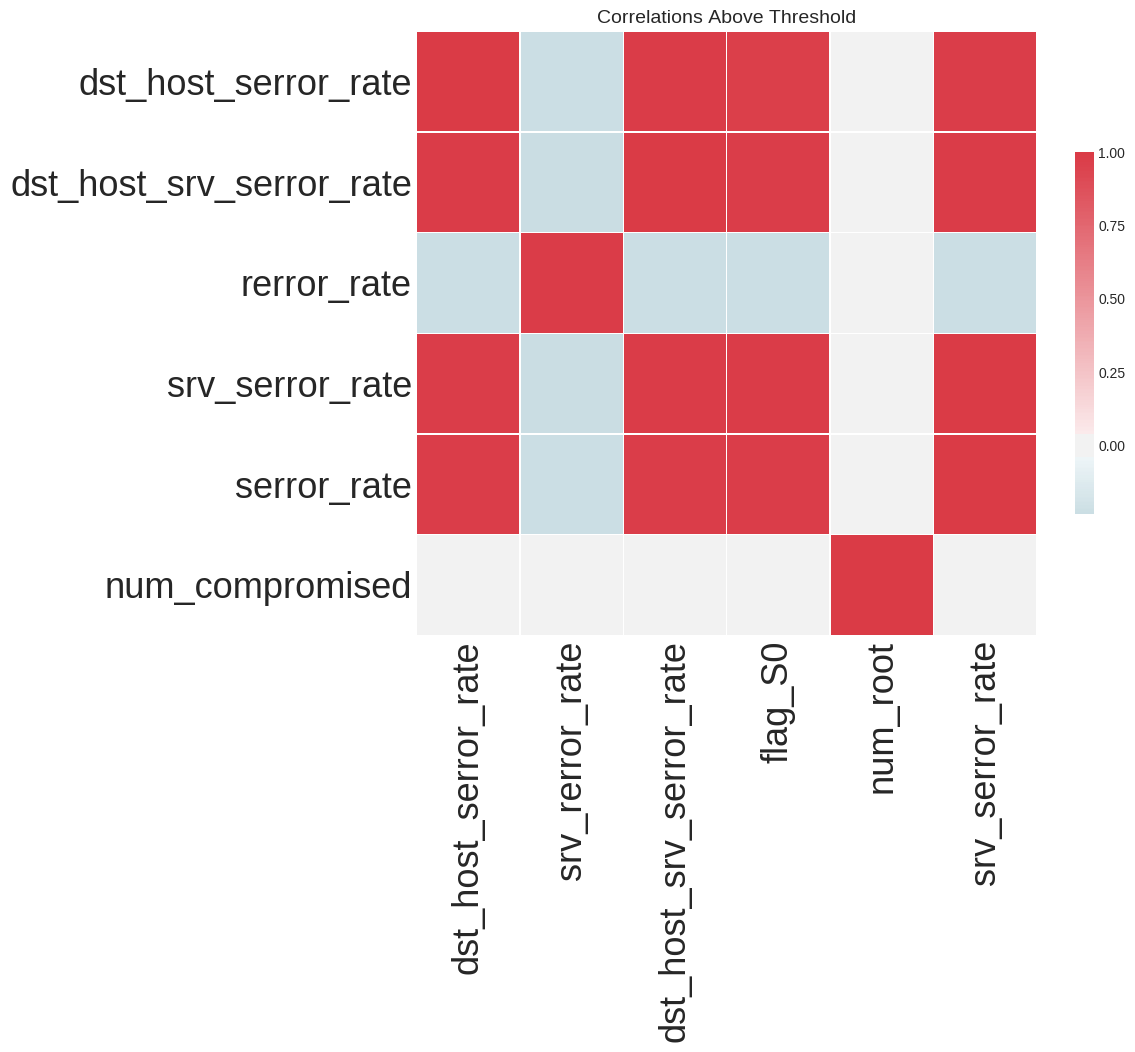

In [ ]:
fs.plot_collinear()

**To plot all of the correlations in the data, we can pass in plot_all = True to the plot_collinear function**

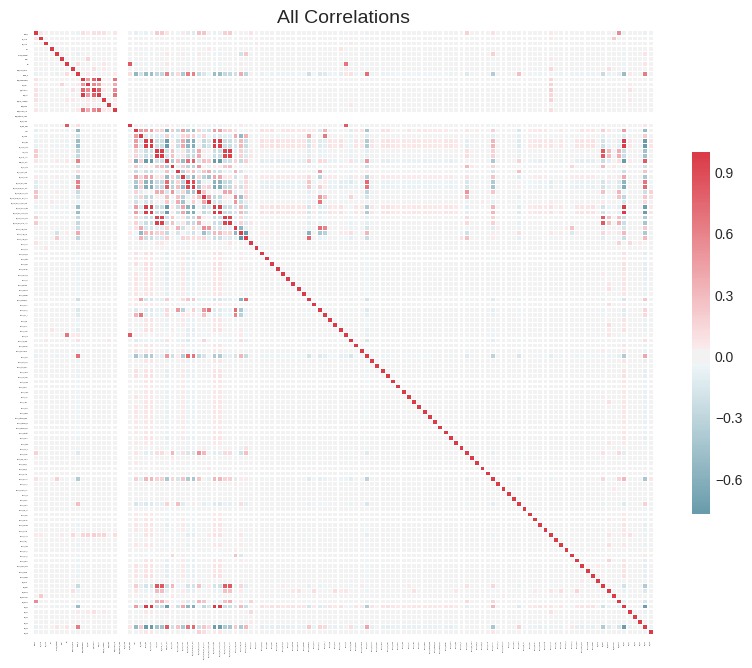

In [ ]:
fs.plot_collinear(plot_all=True)

Now let's see details of correlation. ***The drop_feature will be removed and for each feature that will be removed, there may be several correlations it has with the corr_feature that are above the correlation_threshold***

In [ ]:
fs.record_collinear.head()

,drop_feature,corr_feature,corr_value
0,num_root,num_compromised,0.998956
1,srv_serror_rate,serror_rate,0.993290
2,srv_rerror_rate,rerror_rate,0.989134
3,dst_host_serror_rate,serror_rate,0.978022
4,dst_host_serror_rate,srv_serror_rate,0.976363


##Zero Importance

**This method relies on a machine learning model to identify features to remove. It therefore requires a supervised learning problem with labels. The method works by finding feature importances using a gradient boosting machine**

In [ ]:
fs.identify_zero_importance(task = 'classification', eval_metric = 'auc', 
                            n_iterations = 10, early_stopping = True)

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[258]	valid_0's auc: 0.999988
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[98]	valid_0's auc: 0.999961
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[460]	valid_0's auc: 0.999991
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[162]	valid_0's auc: 0.999997
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[329]	valid_0's auc: 0.999936
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[266]	valid_0's auc: 0.999984
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[224]	valid_0's auc: 0.999957
Training until validation scores don't improve for 100 rounds.
Early st

***Running the gradient boosting model requires one hot encoding the features. These features are saved in the one_hot_features attribute of the FeatureSelector. The original features are saved in the base_features***

In [ ]:
print(len(fs.one_hot_features))
print(len(fs.base_features))

80
41


***The data attribute of the FeatureSelector holds the original dataframe. After one-hot encoding, the data_all attribute holds the original data plus the one-hot encoded features***

In [ ]:
fs.data_all

,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,service_daytime,service_discard,service_domain,service_domain_u,service_echo,service_eco_i,service_ecr_i,service_efs,service_exec,service_finger,service_ftp,service_ftp_data,service_gopher,service_hostnames,service_http,service_http_443,service_http_8001,service_imap4,service_iso_tsap,service_klogin,service_kshell,service_ldap,service_link,service_login,service_mtp,service_name,service_netbios_dgm,service_netbios_ns,service_netbios_ssn,...,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.00,0.00,0.00,0.00,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.00,0.00,0.00,0.00,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.00,1.00,0.00,0.00,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.20,0.20,0.00,0.00,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.00,0.00,0.00,0.00,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,121,19,0.00,0.00,1.00,1.00,0.16,0.06,0.00,255,19,0.07,0.07,0.00,0.00,0.00,0.00,1.00,1.00
6,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,166,9,1.00,1.00,0.00,0.00,0.05,0.06,0.00,255,9,0.04,0.05,0.00,0.00,1.00,1.00,0.00,0.00
7,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,117,16,1.00,1.00,0.00,0.00,0.14,0.06,0.00,255,15,0.06,0.07,0.00,0.00,1.00,1.00,0.00,0.00
8,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,tcp,remote_job,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,270,23,1.00,1.00,0.00,0.00,0.09,0.05,0.00,255,23,0.09,0.05,0.00,0.00,1.00,1.00,0.00,0.00
9,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,133,8,1.00,1.00,0.00,0.00,0.06,0.06,0.00,255,13,0.05,0.06,0.00,0.00,1.00,1.00,0.00,0.00


***There are a number of methods we can use to inspect the results of the feature importances. First we can access the list of features with zero importance***

In [ ]:
fs.ops['zero_importance']

['service_echo',
 'service_tim_i',
 'service_ctf',
 'service_systat',
 'service_supdup',
 'service_ssh',
 'service_sunrpc',
 'service_sql_net',
 'num_failed_logins',
 'service_shell',
 'service_rje',
 'service_urh_i',
 'service_uucp',
 'service_red_i',
 'service_uucp_path',
 'service_vmnet',
 'service_whois',
 'flag_OTH',
 'service_csnet_ns',
 'service_courier',
 'flag_RSTOS0',
 'urgent',
 'service_bgp',
 'land',
 'flag_S2',
 'flag_S3',
 'service_Z39_50',
 'service_remote_job',
 'service_printer',
 'service_daytime',
 'service_ldap',
 'service_exec',
 'is_host_login',
 'num_outbound_cmds',
 'service_gopher',
 'service_hostnames',
 'num_shells',
 'service_http_443',
 'service_http_8001',
 'service_domain',
 'service_iso_tsap',
 'service_klogin',
 'service_kshell',
 'service_link',
 'service_efs',
 'service_login',
 'service_mtp',
 'service_name',
 'service_netbios_dgm',
 'service_netbios_ns',
 'service_netbios_ssn',
 'service_netstat',
 'service_nntp',
 'service_ntp_u',
 'service_discar

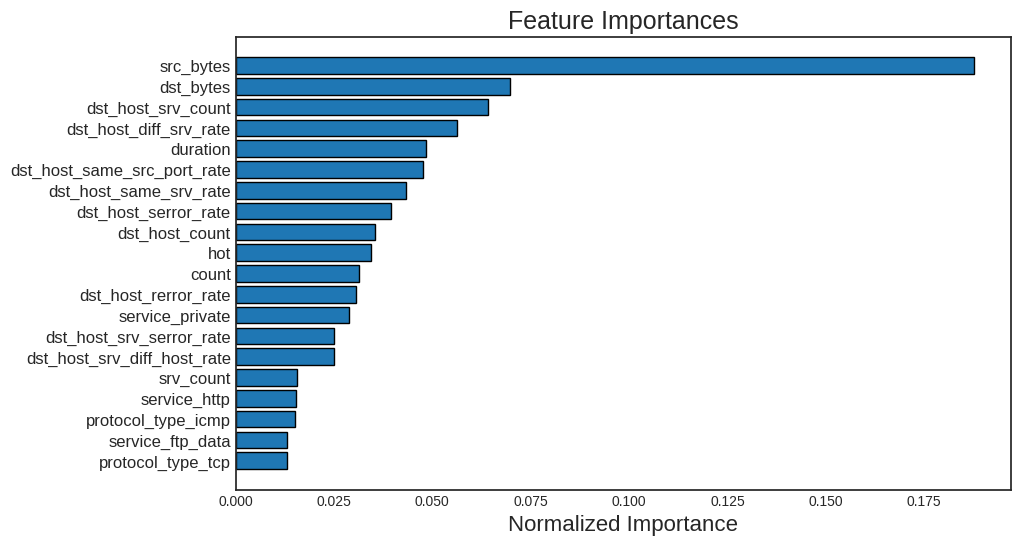

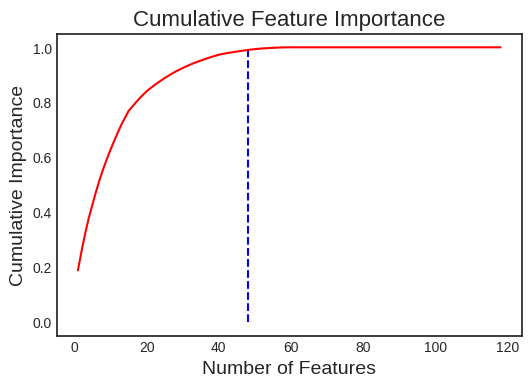

48 features required for 0.99 of cumulative importance


In [ ]:
fs.plot_feature_importances(threshold = 0.99, plot_n = 20)

**All of the feature importances are accessible in the feature_importances attribute of the FeatureSelector**

In [ ]:
fs.feature_importances

,feature,importance,normalized_importance,cumulative_importance
0,src_bytes,1596.5,0.187609,0.187609
1,dst_bytes,594.5,0.069861,0.257471
2,dst_host_srv_count,546.2,0.064186,0.321656
3,dst_host_diff_srv_rate,479.7,0.056371,0.378027
4,duration,411.2,0.048321,0.426349
5,dst_host_same_src_port_rate,406.3,0.047746,0.474094
6,dst_host_same_srv_rate,368.5,0.043304,0.517398
7,dst_host_serror_rate,336.7,0.039567,0.556964
8,dst_host_count,301.2,0.035395,0.592359
9,hot,291.9,0.034302,0.626661


##Low Importance

***This method builds off the feature importances from the gradient boosting machine (identify_zero_importance must be run first) by finding the lowest importance features not needed to reach a specified cumulative total feature importance***

***When using this method, we must have already run identify_zero_importance and need to pass in a cumulative_importance that accounts for that fraction of total feature importance***

In [ ]:
fs.identify_low_importance(cumulative_importance = 0.99)

47 features required for cumulative importance of 0.99 after one hot encoding.
71 features do not contribute to cumulative importance of 0.99.



***The low importance features to remove are those that do not contribute to the specified cumulative importance. These are also available in the ops dictionary***

In [ ]:
fs.ops['low_importance']

['flag_SH',
 'service_auth',
 'flag_REJ',
 'flag_SF',
 'flag_RSTO',
 'su_attempted',
 'root_shell',
 'service_IRC',
 'service_pop_3',
 'is_guest_login',
 'service_urp_i',
 'service_time',
 'service_X11',
 'service_ldap',
 'service_exec',
 'is_host_login',
 'num_outbound_cmds',
 'service_gopher',
 'service_hostnames',
 'num_shells',
 'service_http_443',
 'service_http_8001',
 'service_domain',
 'service_iso_tsap',
 'service_klogin',
 'service_daytime',
 'service_kshell',
 'service_efs',
 'service_login',
 'service_mtp',
 'service_name',
 'service_netbios_dgm',
 'service_netbios_ns',
 'service_netbios_ssn',
 'service_netstat',
 'service_nntp',
 'service_ntp_u',
 'service_discard',
 'service_pm_dump',
 'service_link',
 'service_pop_2',
 'service_printer',
 'service_Z39_50',
 'service_echo',
 'service_tim_i',
 'service_ctf',
 'service_systat',
 'service_supdup',
 'service_ssh',
 'service_sunrpc',
 'service_sql_net',
 'num_failed_logins',
 'service_shell',
 'service_rje',
 'service_urh_i',


##Single Unique Value

***The next method is straightforward: find any features that have only a single unique value.***

In [ ]:
fs.identify_single_unique()

2 features with a single unique value.



Now we can see which features have a single value

In [ ]:
fs.ops['single_unique']

['num_outbound_cmds', 'is_host_login']

Let's plot the number of unique values in each feature of the dataset

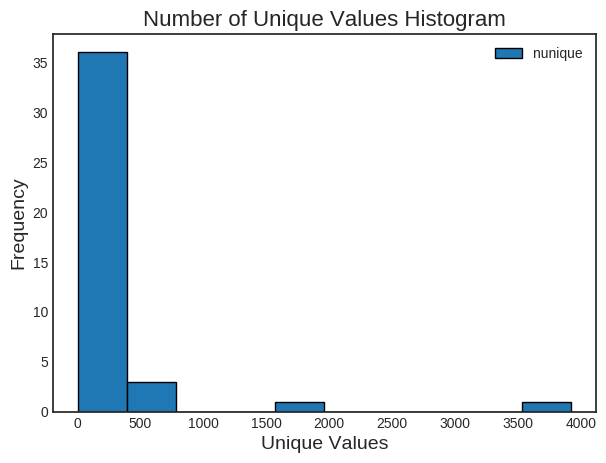

In [ ]:
fs.plot_unique()

If you want a detailed information use

In [ ]:
fs.unique_stats

,nunique
is_host_login,1
num_outbound_cmds,1
is_guest_login,2
num_shells,2
root_shell,2
logged_in,2
land,2
urgent,2
su_attempted,3
protocol_type,3


##Missing Values

***The first feature selection method is straightforward: find any columns with a missing fraction greater than a specified threshold.***

In this example we will use a threshold of 0.7 which mean to finding features with more than 70% of missing values.

***In these datasets there is no lack of data, so in this case it is just showing how the function would work***

In [ ]:
fs.identify_missing(missing_threshold=0.7)

0 features with greater than 0.70 missing values.



In case some features can be removed, you can see them as follows

In [ ]:
fs.ops['missing']

[]

Also, we can plot the result

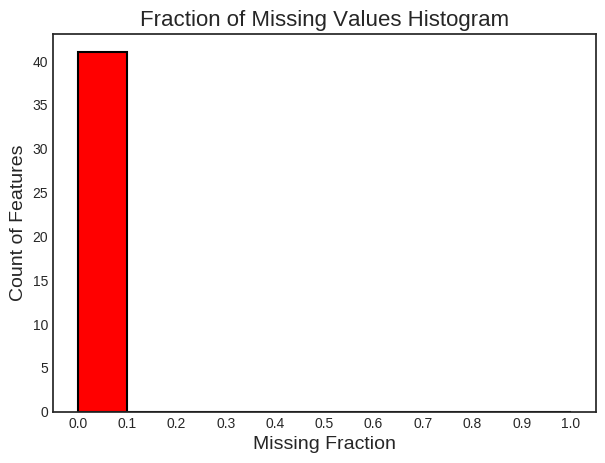

In [ ]:
fs.plot_missing()

If you want a detailed information use

In [ ]:
fs.missing_stats

,missing_fraction
duration,0.0
is_guest_login,0.0
srv_count,0.0
serror_rate,0.0
srv_serror_rate,0.0
rerror_rate,0.0
srv_rerror_rate,0.0
same_srv_rate,0.0
diff_srv_rate,0.0
srv_diff_host_rate,0.0
